# Give Me Some Credit - Kaggle Competition
### Honest Bee - Data Scientist
This challenge was done as part of the Job application for Honest Bee
This competition requires participants to improve on the state of the art in credit scoring, by **predicting the probability that somebody will experience financial distress in the next two years.**

In [46]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load and clean the dataset

In [329]:
# Read the input files in
df_train = pd.read_csv('cs-training.csv')
df_test = pd.read_csv('cs-test.csv')
df_sample_entry = pd.read_csv('sampleEntry.csv')

# Clean up the df to remove the extra column at the start
del df_train[u'Unnamed: 0']
del df_test[u'Unnamed: 0']
del df_test['SeriousDlqin2yrs']

In [330]:
#How to deal with missing/ NA values.
#Current suggestion is to convert them to zero and move on. 
#More investigation required on exact reason for missing values

df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [8]:
# Structure of the sample output the model needs to produce.
df_sample_entry.head()

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264


## Some basic feature exploration using data viz

In [58]:
# Get some basic stats on the training data
print 'Percentage of each target var class in the data:'
display(df_train.SeriousDlqin2yrs.value_counts()/len(df_train))

#High level descriptive stats on all the other fields.
display(df_train.describe())

Percentage of each target var class in the data:


0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,NaN,5.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,0.154181,52.000000,0.000000,0.366508,NaN,8.000000,0.000000,1.000000,0.000000,NaN
75%,0.000000,0.559046,63.000000,0.000000,0.868254,NaN,11.000000,0.000000,2.000000,0.000000,NaN
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [360]:
def build_scatter_plots(data, x_field, y_field, x_log=False, y_log = False):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data[x_field], data[y_field])
    plt.xlabel(x_field)
    plt.ylabel(y_field)
    if x_log:
        ax.set_xscale('log')
    if y_log:
        ax.set_yscale('log')
    plt.show()

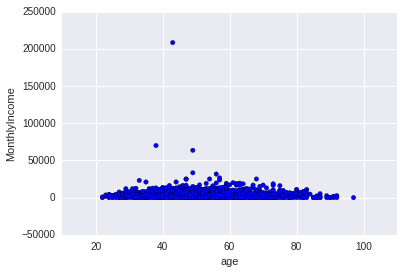

In [361]:
build_scatter_plots(df_train.iloc[:1000,], 'age','MonthlyIncome',x_log=False, y_log=False )

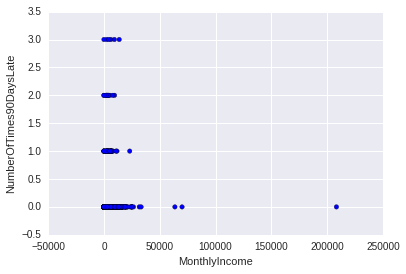

In [362]:
build_scatter_plots(df_train.iloc[:1000,], 'MonthlyIncome','NumberOfTimes90DaysLate',x_log=False, y_log=False )

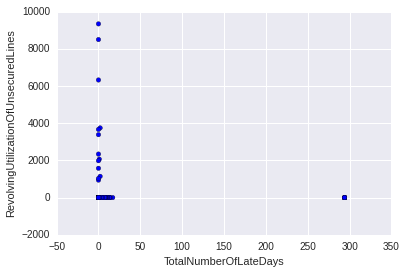

In [378]:
build_scatter_plots(df_train.iloc[:10000,], 'TotalNumberOfLateDays','RevolvingUtilizationOfUnsecuredLines',x_log=False, y_log=False )

## Feature engineering
Some basic additional features being added to the model

In [331]:
def add_feats(df):
    #Add some more engineered features to the dataset
    
    #Total sum of the delay days from the three bins
    df['TotalNumberOfLateDays'] = df['NumberOfTime30-59DaysPastDueNotWorse']\
                                  + df['NumberOfTime60-89DaysPastDueNotWorse']\
                                  + df['NumberOfTimes90DaysLate']
            
    #Absolute Debt value instead of DebtRatio
    df['DebtValue'] = df['MonthlyIncome'] - (df['MonthlyIncome'] * df['DebtRatio'])
    
    #Income on log scale
    df['LogMonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: log1p(x))
    
    #Income to Dependent ratio
    df['DependentIncomeRatio'] = df['MonthlyIncome'] / (1+df['NumberOfDependents'])
    
    return df    

In [332]:
df_train = add_feats(df_train)
df_test = add_feats(df_test)

## Model building

In [312]:
def build_and_test_model(X_train, y_train, X_test, y_test, clf_func, **kwargs):
    from sklearn import cross_validation
    
    clf = clf_func(**kwargs)
    
    print 'Model name: ** %s **' % clf_func.__name__
    clf.fit(X_train, y_train)
    print '\tAccuracy on the training set: %.5f' % clf.score(X_train, y_train)
    print("\tAccuracy on the hold out set: %.5f" % ( clf.score(X_test, y_test)))
    
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv = 5)
    print("\tAccuracy using 5-fold CV on train set: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
    
    #Returns all the four classifier models. User will choose which one is the best
    return clf

In [391]:
def build_roc_curve(X, y, model_list, model_name):
    from sklearn.metrics import roc_curve, auc
    for i in range(len(model_list)):
        scores = model_list[i].predict_proba(X)
        fpr, tpr, thresholds = roc_curve(y,scores[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s - AUC = %0.5f' % (model_name[i], roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='lower right')
    plt.savefig('ROC_Curve.pdf', orientation = 'landscape')
    plt.show()
    

In [244]:
def rf_feat_importance(rf_model , X, n=10):
    #Given the random forest model, will output the top n features by importance
    importances= rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Top 10 Features - Feature ranking:")
    for f in range(n):
        print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]] , importances[indices[f]]))

In [281]:
def build_confusion_matrix(X, y, model_list, model_name):
    from sklearn.metrics import confusion_matrix
    for i in range(len(model_list)):
        preds = model_list[i].predict(X)
        print '** confusion matrix for model %s **' % model_name[i]
        cm = confusion_matrix(y, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ' \t0\t1'
        print '--------------------'
        print '0\t%.3f\t%.3f' % (cm_normalized[0][0], cm_normalized[0][1])
        print '1\t%.3f\t%.3f' % (cm_normalized[1][0], cm_normalized[1][1])
        print '--------------------'

## Evaluate four different classifiers
**Naive Bayes, Logistic Regression , AdaBoost Classifier, and Random Forest Classifier**

Train on the training set, and accuracy measured on the hold out set or k-fold cv set

In [333]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

X = df_train.ix[:,1:]
y = df_train.ix[:,0]

#Use traditional train , test split for training and validating the model.
#Hold out set/ validation set size = 30%
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, 
                                                                         random_state=0)
model_nb = build_and_test_model(X_train, y_train, X_test, y_test, GaussianNB)
model_lreg= build_and_test_model(X_train, y_train, X_test, y_test, LogisticRegression, C=0.9)
model_adab= build_and_test_model(X_train, y_train, X_test, y_test, AdaBoostClassifier)
model_rf = build_and_test_model(X_train, y_train, X_test, y_test, RandomForestClassifier, max_depth=10, n_estimators=500)

Model name: ** GaussianNB **
	Accuracy on the training set: 0.93301
	Accuracy on the hold out set: 0.93262
Model name: ** LogisticRegression **
	Accuracy on the training set: 0.93343
	Accuracy on the hold out set: 0.93264
Model name: ** AdaBoostClassifier **
	Accuracy on the training set: 0.93574
	Accuracy on the hold out set: 0.93480
Model name: ** RandomForestClassifier **
	Accuracy on the training set: 0.94725
	Accuracy on the hold out set: 0.93656


In [334]:
build_confusion_matrix(X_test, y_test, [model_nb, model_lreg, model_adab, model_rf], 
                [GaussianNB.__name__, LogisticRegression.__name__, AdaBoostClassifier.__name__,
                 RandomForestClassifier.__name__])

** confusion matrix for model GaussianNB **
 	0	1
--------------------
0	0.998	0.002
1	0.977	0.023
--------------------
** confusion matrix for model LogisticRegression **
 	0	1
--------------------
0	0.999	0.001
1	0.989	0.011
--------------------
** confusion matrix for model AdaBoostClassifier **
 	0	1
--------------------
0	0.987	0.013
1	0.785	0.215
--------------------
** confusion matrix for model RandomForestClassifier **
 	0	1
--------------------
0	0.993	0.007
1	0.841	0.159
--------------------


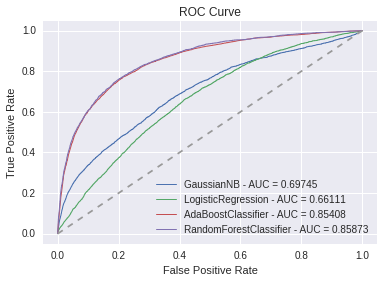

In [392]:
build_roc_curve(X_test, y_test, [model_nb, model_lreg, model_adab, model_rf], 
                [GaussianNB.__name__, LogisticRegression.__name__,  AdaBoostClassifier.__name__,
                 RandomForestClassifier.__name__])

In [336]:
rf_feat_importance(model_rf, X_train, n=10)

Top 10 Features - Feature ranking:
1. feature TotalNumberOfLateDays (0.222451)
2. feature NumberOfTimes90DaysLate (0.185545)
3. feature RevolvingUtilizationOfUnsecuredLines (0.150280)
4. feature NumberOfTime60-89DaysPastDueNotWorse (0.082537)
5. feature NumberOfTime30-59DaysPastDueNotWorse (0.071259)
6. feature age (0.046956)
7. feature DebtRatio (0.046210)
8. feature DebtValue (0.040208)
9. feature DependentIncomeRatio (0.034198)
10. feature NumberOfOpenCreditLinesAndLoans (0.033503)


## Best model - RF Classifier
Out of the four chosen hypothesis models, the **RF Classifier does the best on the hold out set**.
Now we can use this model to generate the predictions on the test set.


In [248]:
def save_test_predictions(scores):
    #Given the predictions made on the test set, save it to a csv file in the right format
    df_scores =  pd.DataFrame(scores)
    df_scores.reset_index(inplace= True)
    df_scores.columns = ['Id','Probability']
    #Incrementing the ID column by 1
    df_scores.Id = df_scores.Id + 1
    df_scores.to_csv('predictions.csv', index=False)

In [296]:
scores = model_rf.predict_proba(df_test.fillna(0))[:,1]
save_test_predictions(scores)